In [1]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

# Plotting
from matplotlib import pyplot as plt
import plotly

# Other
import time
import copy
from tqdm.notebook import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading
from noisyopt import minimizeSPSA
import optuna # Automatic tuning tool

import multiprocessing

import warnings
warnings.filterwarnings("ignore", message="For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.")

##############

In [2]:
# My functions:
import vqe_functions as vqe
import qcnn_functions as qcnn


## VQE

In [3]:
N = 4
J = 1
l_steps = 100
shift_invariance = 0

lams = np.linspace(0,2*J,l_steps)

step_size = 0.03
epochs = 250
shift_invariance = 0

In [4]:
dev_vqe_default = qml.device('default.qubit', wires = N, shots = None)
dev_vqe_mixed   = qml.device("default.mixed", wires = N, shots = None)

In [5]:
@qml.qnode(dev_vqe_default)
def vqe_cost_fn_default(vqe_params, N, shift_invariance, H):
    vqe.circuit(N, vqe_params, shift_invariance)
        
    # return <psi|H|psi>
    return qml.expval(H)

@qml.qnode(dev_vqe_mixed)
def vqe_cost_fn_mixed(vqe_params, N, shift_invariance, H, p_noise = 0, p_noise_ent = 0):
    vqe.circuit(N, vqe_params, shift_invariance, p_noise, p_noise_ent)
        
    # return <psi|H|psi>
    return qml.expval(H)


#### VQE learning functions:

* ***vqe.train()***: (first) standard learning function:
    * <span style="color: green;">Parameters recycling (final learnt gates are the initial parameters of next datapoint/state)</span>
    * <span style="color: red;">Single core (No Multiprocessing)</span>
* ***vqe.mptrain()***: Multiprocessed version of standard learning function:
    * ***Optimizer == Adam:***
        * <span style="color: green;">Multi core</span>
        * <span style="color: green;">Pre-training with parameters recycling</span>
        * <span style="color: green;">Automatically removing from training states with a relative error below a CUTOFF</span>
        * <span style="color: red;">No parameter recycling during training (less smooth results)</span>
    * ***Optimizer == SPSA:***
        * <span style="color: green;">Multi core</span>
        * <span style="color: green;">Pre-training with parameters recycling</span>
        * <span style="color: green;">SPSA optimizer</span>
        * <span style="color: red;">No parameter recycling during training (less smooth results)</span>
        * <span style="color: red;">No progress-bar</span>

### VQE on noiseless Circuit

***Parameters:***

step_size    = 0.03 (Step size of the optimizer)
random_shift = 0 (Random shift of parameters of the optimizer)
n_epochs     = 250 (# epochs for the other GSs)
N            = 4 (Number of spins of the system)


***Circuit:***

0: ──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)─┤ ╭<𝓗>
1: ──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)─┤ ├<𝓗>
2: ──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)─┤ ├<𝓗>
3: ──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)─┤ ╰<𝓗>

Preparing states:


  0%|          | 0/34 [00:00<?, ?it/s]

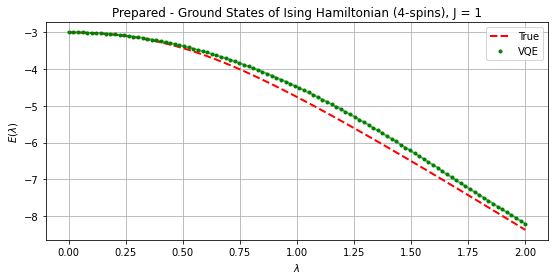

  0%|          | 0/250 [00:00<?, ?it/s]

/home/saverio/anaconda3/envs/qua/lib/python3.10/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



['./vqe_states_job/vqe_params_0noise.job']

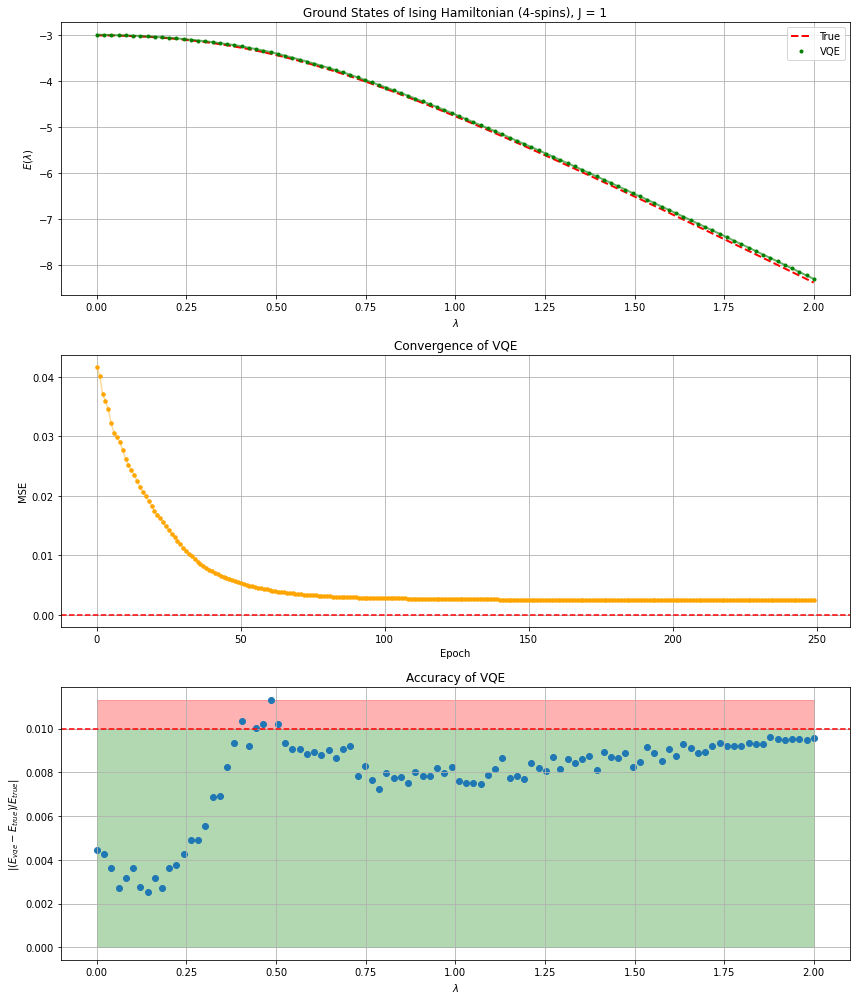

In [84]:
vqe_e, errs, thetas, ys = vqe.mptrain(step_size, epochs, N, J, l_steps, vqe_cost_fn_mixed, optimizer = 'Adam',
                                             shift_invariance = shift_invariance, p_noise = 0, p_noise_ent = 0,
                                             circuit = True, plots = True, prepare_states = True, preplots = True,
                                             prep_step_size = 0.05)

vqe_data_x = thetas 
vqe_data_y = ys
    
vqe_data = []
for i in range(len(vqe_data_x)):
    vqe_data.append((vqe_data_x[i],vqe_data_y[i]))
    
vqe_data = np.array(vqe_data)

joblib.dump(vqe_data, './vqe_states_job/vqe_params_0noise.job')


### VQE on noisy Circuit

#### p-noise = 0.001

***Parameters:***

step_size    = 0.03 (Step size of the optimizer)
random_shift = 0 (Random shift of parameters of the optimizer)
n_epochs     = 100 (# epochs for the other GSs)
N            = 4 (Number of spins of the system)


***Circuit:***

0: ──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)─┤ ╭<𝓗>
1: ──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)─┤ ├<𝓗>
2: ──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)─┤ ├<𝓗>
3: ──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)─┤ ╰<𝓗>

Preparing states:


  0%|          | 0/34 [00:00<?, ?it/s]

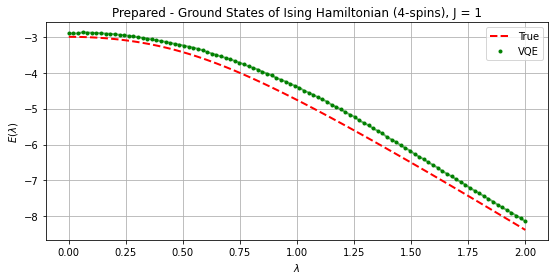

  0%|          | 0/100 [00:00<?, ?it/s]

MSE: 0.014749307085270598


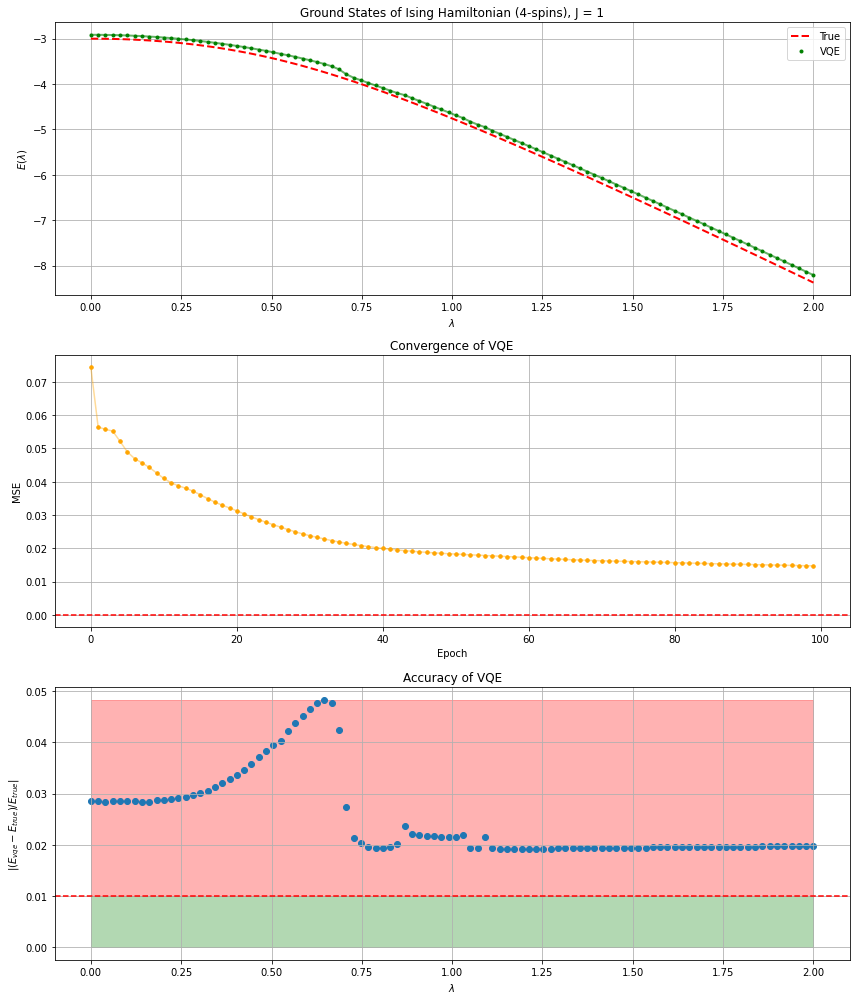

In [9]:
vqe_e, errs, thetas, ys = vqe.mptrain(step_size = 0.03, n_epochs = 100, random_shift = 0, N = N, J = J, l_steps = 100, vqe_cost_fn = vqe_cost_fn_mixed, 
                                      optimizer = 'Adam',
                                      shift_invariance = 0, p_noise = 0.001, p_noise_ent = 0.001,
                                      circuit = True, plots = True, prepare_states = True, preplots = True,
                                      prep_step_size = 0.1)

vqe_data_x = thetas 
vqe_data_y = ys
    
vqe_data = []
for i in range(len(vqe_data_x)):
    vqe_data.append((vqe_data_x[i],vqe_data_y[i]))
    
vqe_data = np.array(vqe_data)

joblib.dump(vqe_data, './vqe_states_job/vqe_params_0.001noise.job')

print('MSE:', errs[-1])

#### p-noise = 0.005

***Parameters:***

step_size    = 0.03 (Step size of the optimizer)
random_shift = 0 (Random shift of parameters of the optimizer)
n_epochs     = 100 (# epochs for the other GSs)
N            = 4 (Number of spins of the system)


***Circuit:***

0: ──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)─┤ ╭<𝓗>
1: ──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)─┤ ├<𝓗>
2: ──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)─┤ ├<𝓗>
3: ──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)─┤ ╰<𝓗>

Preparing states:


  0%|          | 0/34 [00:00<?, ?it/s]

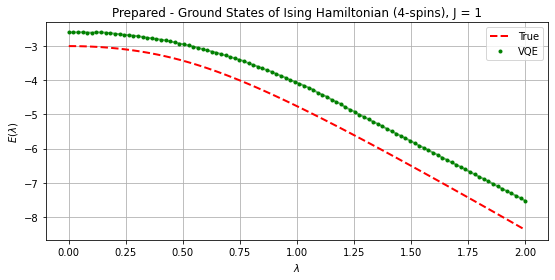

  0%|          | 0/100 [00:00<?, ?it/s]

MSE: 0.2750009608826483


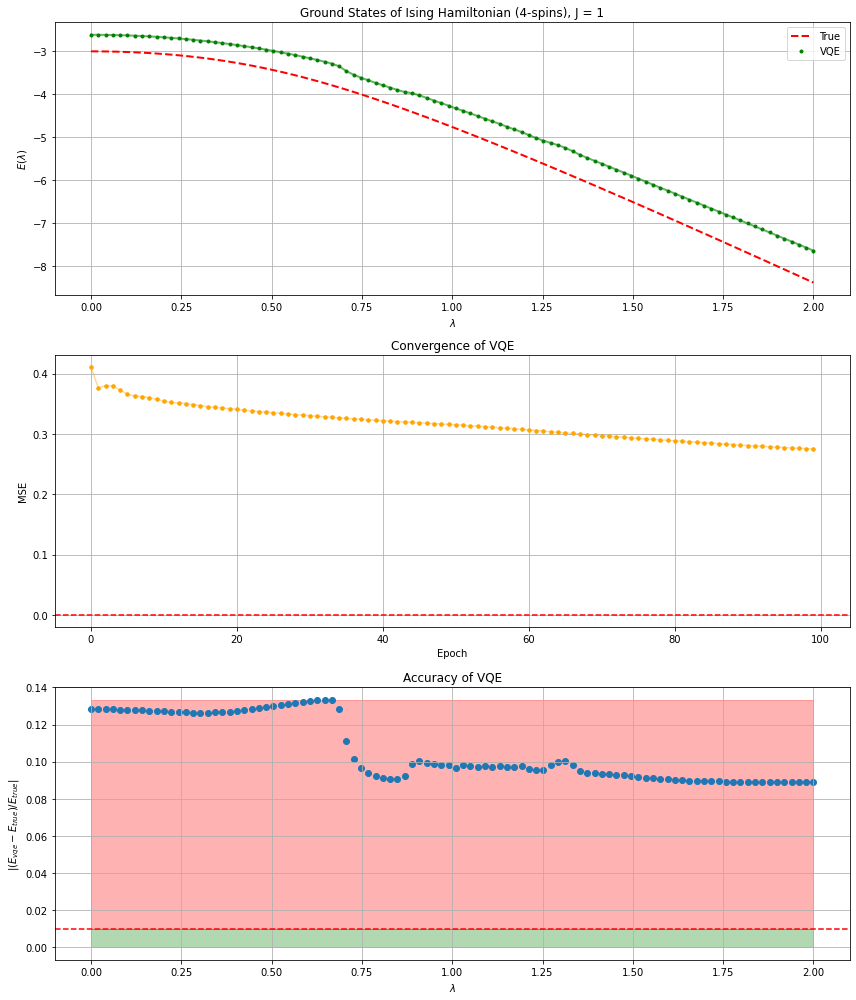

In [10]:
vqe_e, errs, thetas, ys = vqe.mptrain(step_size = 0.03, n_epochs = 100, random_shift = 0, N = N, J = J, l_steps = 100, vqe_cost_fn = vqe_cost_fn_mixed, 
                                      optimizer = 'Adam',
                                      shift_invariance = 0, p_noise = 0.005, p_noise_ent = 0.005,
                                      circuit = True, plots = True, prepare_states = True, preplots = True,
                                      prep_step_size = 0.1)

vqe_data_x = thetas 
vqe_data_y = ys
    
vqe_data = []
for i in range(len(vqe_data_x)):
    vqe_data.append((vqe_data_x[i],vqe_data_y[i]))
    
vqe_data = np.array(vqe_data)

joblib.dump(vqe_data, './vqe_states_job/vqe_params_0.005noise.job')

print('MSE:', errs[-1])

## QCNN

In [12]:
# Load data:

# Load data and separate in training and test set
data_noisy001 = joblib.load('./vqe_states_job/vqe_params_0.001noise.job')

train_index_noisy001 = np.sort(np.random.choice(np.arange(len(data_noisy001)), size=int(0.8*len(data_noisy001)), replace=False ))

X_train_noisy001, Y_train_noisy001 = [], []
X_test_noisy001, Y_test_noisy001   = [], []

for i in range(len(data_noisy001)): 
    if i in train_index_noisy001:
        X_train_noisy001.append(data_noisy001[i][0])
        Y_train_noisy001.append(data_noisy001[i][1])
    else:
        X_test_noisy001.append(data_noisy001[i][0])
        Y_test_noisy001.append(data_noisy001[i][1])
        
#X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
#X_test, Y_test   = jnp.array(X_test), jnp.array(Y_test)


print('NOISY DATA (p noise = 0.001):')
print('______________________________')
print('Size of Data Set: {0}'.format(len(data_noisy001)))
print('Size of Training Set: {0}'.format(np.shape(X_train_noisy001)[0]))
print('Size of Test Set    : {0}\n'.format(np.shape(X_test_noisy001)[0]))

# Load data and separate in training and test set
data_noisy005 = joblib.load('./vqe_states_job/vqe_params_0.005noise.job')

train_index_noisy005 = np.sort(np.random.choice(np.arange(len(data_noisy005)), size=int(0.8*len(data_noisy005)), replace=False ))

X_train_noisy005, Y_train_noisy005 = [], []
X_test_noisy005, Y_test_noisy005   = [], []

for i in range(len(data_noisy005)): 
    if i in train_index_noisy005:
        X_train_noisy005.append(data_noisy005[i][0])
        Y_train_noisy005.append(data_noisy005[i][1])
    else:
        X_test_noisy005.append(data_noisy005[i][0])
        Y_test_noisy005.append(data_noisy005[i][1])
        
#X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
#X_test, Y_test   = jnp.array(X_test), jnp.array(Y_test)


print('NOISY DATA (p noise = 0.005):')
print('______________________________')
print('Size of Data Set: {0}'.format(len(data_noisy005)))
print('Size of Training Set: {0}'.format(np.shape(X_train_noisy005)[0]))
print('Size of Test Set    : {0}\n'.format(np.shape(X_test_noisy005)[0]))


# Load data and separate in training and test set
data = joblib.load('./vqe_states_job/vqe_params_0noise.job')

train_index = np.sort(np.random.choice(np.arange(len(data)), size=int(0.8*len(data)), replace=False ))

X_train, Y_train = [], []
X_test, Y_test   = [], []

for i in range(len(data_noisy)): 
    if i in train_index_noisy:
        X_train.append(data[i][0])
        Y_train.append(data[i][1])
    else:
        X_test.append(data[i][0])
        Y_test.append(data[i][1])
        
#X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
#X_test, Y_test   = jnp.array(X_test), jnp.array(Y_test)


print('CLEAN DATA:')
print('______________________________')
print('Size of Data Set: {0}'.format(len(data)))
print('Size of Training Set: {0}'.format(np.shape(X_train)[0]))
print('Size of Test Set    : {0}'.format(np.shape(X_test)[0]))

NOISY DATA (p noise = 0.001):
______________________________
Size of Data Set: 100
Size of Training Set: 80
Size of Test Set    : 20

NOISY DATA (p noise = 0.005):
______________________________
Size of Data Set: 100
Size of Training Set: 80
Size of Test Set    : 20

CLEAN DATA:
______________________________
Size of Data Set: 100
Size of Training Set: 80
Size of Test Set    : 20


In [13]:
@qml.qnode(dev_vqe_mixed)
def qcnn_circuit(params_vqe, vqe_shift_invariance, params, N, vqe_conv_noise = 0, vqe_rot_noise = 0, qcnn_conv_noise = 0, qcnn_pool_noise = 0):
    qcnn.qcnn(params_vqe, vqe_shift_invariance, params, N, vqe_conv_noise, vqe_rot_noise, qcnn_conv_noise, qcnn_pool_noise)
    
    return qml.probs(wires = N - 1)

***Parameters:***

  0%|          | 0/500 [00:00<?, ?it/s]

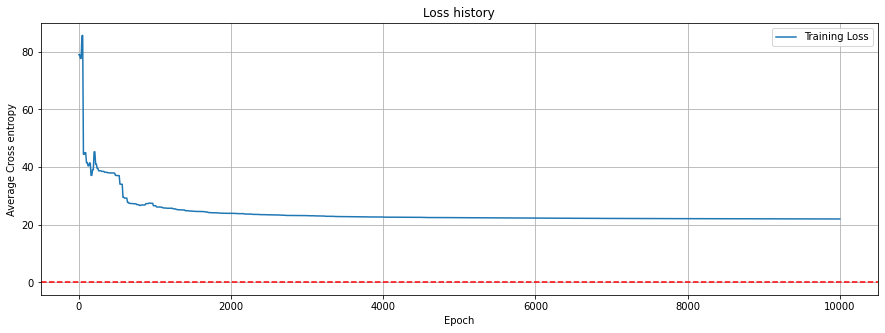

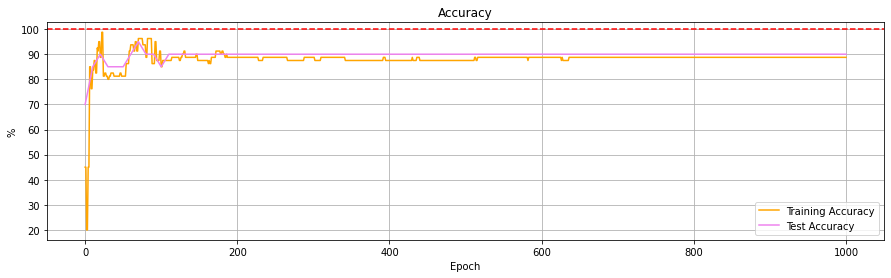

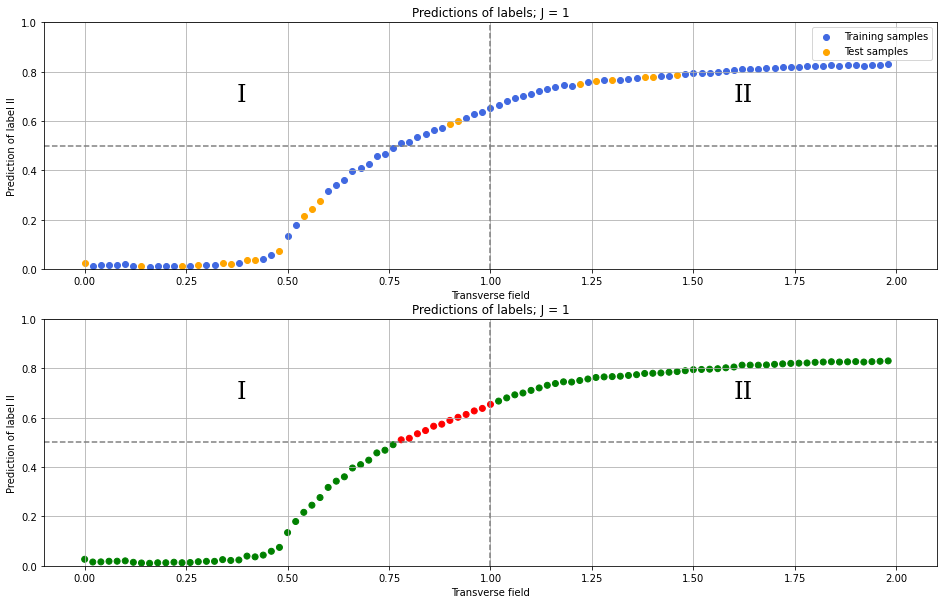

In [14]:
# Noisy-less Circuit
loss_history, accuracy_history, params = qcnn.train(500, 0.05, 0.0008, 0, N, 0, 0, 0, 0,
                                                    qcnn_circuit, X_train, Y_train, X_test, Y_test, plot = True)
qcnn.plot_results_classification(data, train_index, params, 0, N, qcnn_circuit,
                                vqe_conv_noise = 0, vqe_rot_noise = 0, qcnn_conv_noise = 0, qcnn_pool_noise = 0)

***Parameters:***

  0%|          | 0/500 [00:00<?, ?it/s]

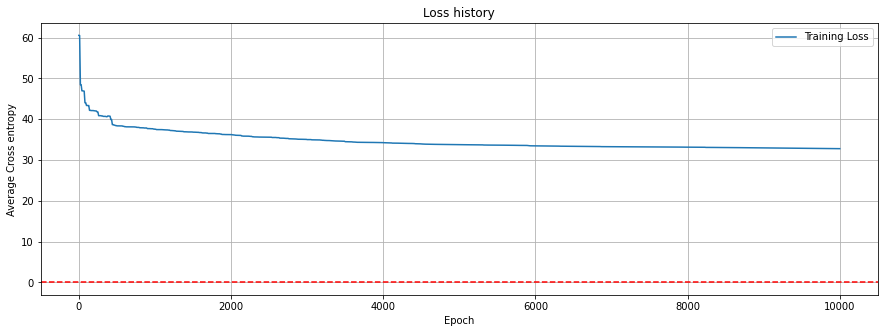

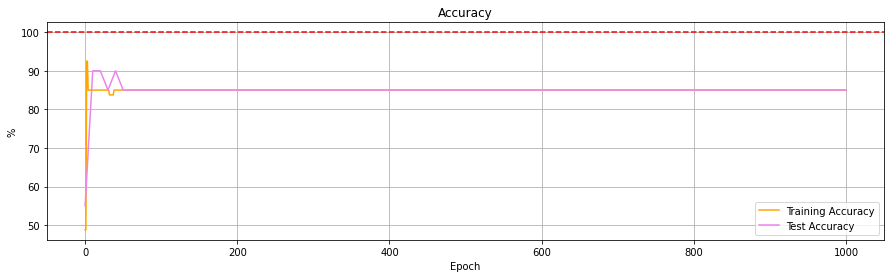

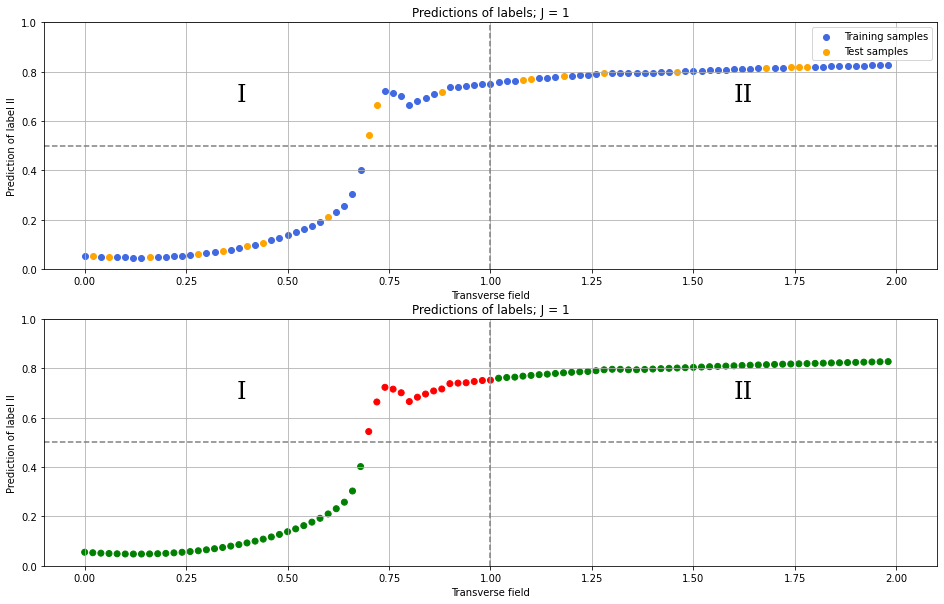

In [18]:
loss_history, accuracy_history, params_noisy005 = qcnn.train(500, 0.05, 0.0008, 0, N, 0.005, 0.005, 0.005, 0.005,
                                                    qcnn_circuit, X_train_noisy005, Y_train_noisy005, X_test_noisy005, Y_test_noisy005, plot = True)
qcnn.plot_results_classification(data_noisy005, train_index_noisy005, params_noisy005, 0, N, qcnn_circuit,
                                vqe_conv_noise = 0, vqe_rot_noise = 0, qcnn_conv_noise = 0, qcnn_pool_noise = 0)

## Backup code:

### Backup code: Optuna hyperparameter optimization framework

***Parameters:***

step_size    = 0.0 (Step size of the optimizer)
random_shift = 0 (Random shift of parameters of the optimizer)
n_epochs     = 0 (# epochs for the other GSs)
N            = 4 (Number of spins of the system)

Preparing states:


  0%|          | 0/4 [00:00<?, ?it/s]

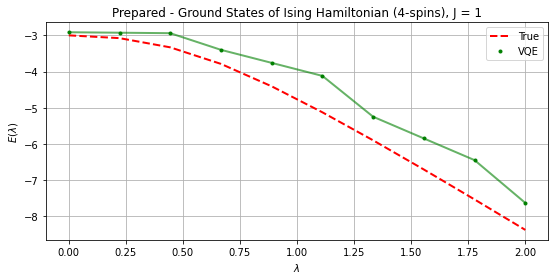

0it [00:00, ?it/s]

In [9]:
_, _, preparams, _ = vqe.mptrain(step_size = 0.0, n_epochs = 0, N = 4, J = 1, l_steps = 10, vqe_cost_fn = vqe_cost_fn_mixed, optimizer = 'Adam',
                                 random_shift = 0, shift_invariance = 0, p_noise = 0.001, p_noise_ent = 0.001, 
                                 circuit = False, plots = False, prepare_states = True, preplots = True,
                                 prep_step_size = 0.1, cutoff_value = 0.01, pretrained = [])

In [25]:
def optuna_find_hparameters(ntrials = 20, nepochs = 10):
    '''
    Function for Optuna hyperparameter tuning
    '''
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='minimize')
    
    def optuna_train(trial):
        '''
        Main function for optuna.
        '''
        epochs = nepochs
        cfg = {
          'step_size': trial.suggest_loguniform('step_size',1e-4,1e0),
          'random_shift': trial.suggest_loguniform('random_shift',1e-8,1e1)
        }
        
        vqe_e, errs, thetas, ys = vqe.mptrain(step_size = cfg['step_size'], n_epochs = nepochs, N = 4, J = 1, l_steps = 10, vqe_cost_fn = vqe_cost_fn_mixed, optimizer = 'SPSA',
                                              random_shift = cfg['random_shift'], shift_invariance = 0, p_noise = 0.001, p_noise_ent = 0.001, 
                                              circuit = False, plots = False, prepare_states = False, preplots = False, parameter_info = False,
                                              prep_step_size = 0.1, cutoff_value = 0.01, pretrained = preparams)

        return errs[-1]
    
    study.optimize(optuna_train, n_trials=ntrials)
    
    return study

In [26]:
study = optuna_find_hparameters(ntrials = 100, nepochs = 100)

[I 2022-06-12 11:52:47,001] A new study created in memory with name: no-name-82d36d45-3167-4ecb-816b-e68652c1cd7d
[I 2022-06-12 11:53:18,736] Trial 0 finished with value: 0.2799952988244302 and parameters: {'step_size': 0.012975660588800071, 'random_shift': 0.16749757474414018}. Best is trial 0 with value: 0.2799952988244302.
[I 2022-06-12 11:53:50,942] Trial 1 finished with value: 0.4507885150066757 and parameters: {'step_size': 0.0007065811550388274, 'random_shift': 7.2901435877673844e-06}. Best is trial 0 with value: 0.2799952988244302.
[I 2022-06-12 11:54:23,702] Trial 2 finished with value: 0.46077464079892894 and parameters: {'step_size': 0.0002685852930445999, 'random_shift': 1.0133077876973438e-08}. Best is trial 0 with value: 0.2799952988244302.
[I 2022-06-12 11:54:56,273] Trial 3 finished with value: 1.075612760271807 and parameters: {'step_size': 0.13239145194299923, 'random_shift': 1.7803683623823354}. Best is trial 0 with value: 0.2799952988244302.
[I 2022-06-12 11:55:28,6

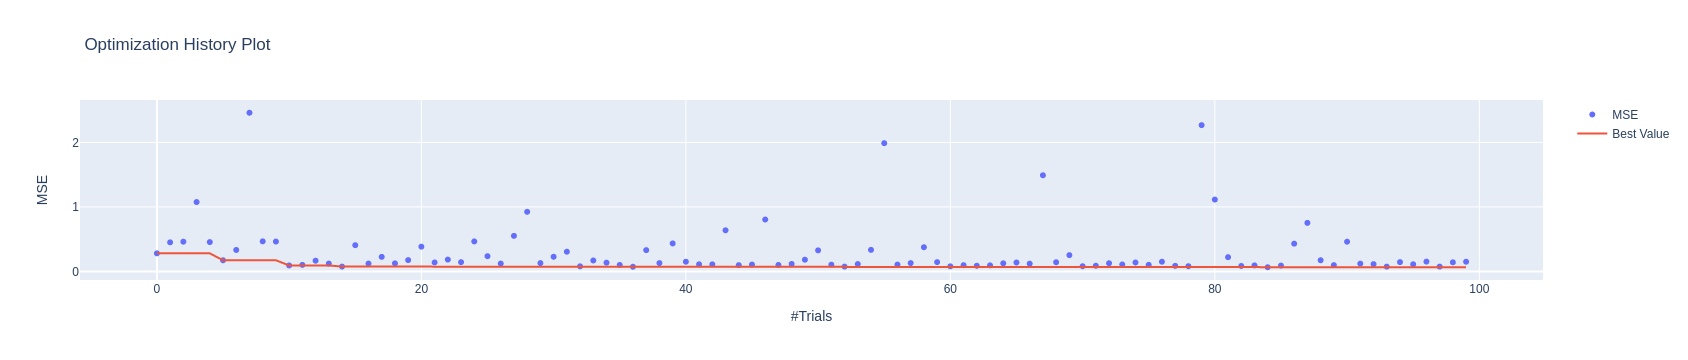

In [27]:
optuna.visualization.plot_optimization_history(study, target_name='MSE')


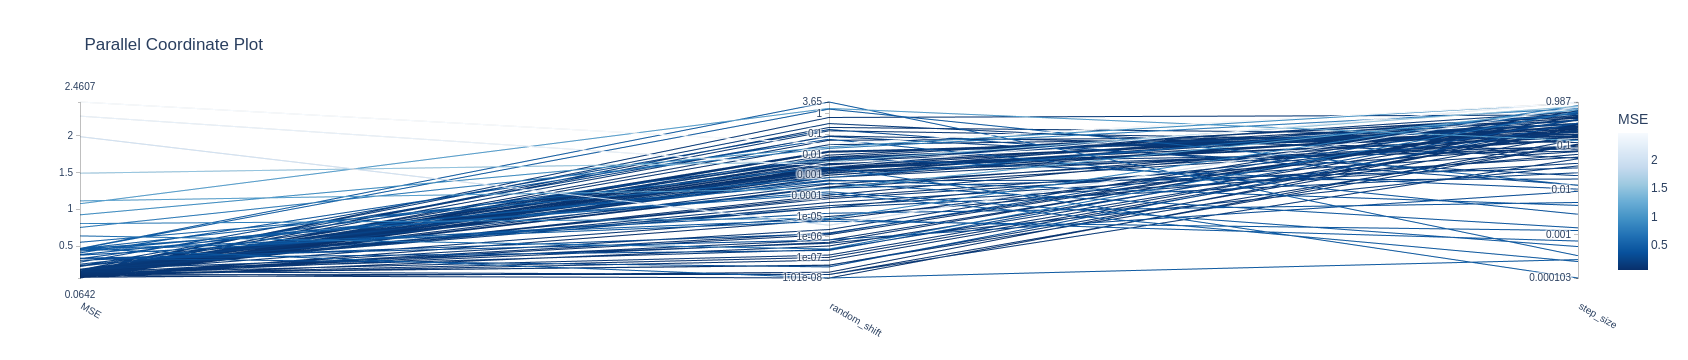

In [28]:
optuna.visualization.plot_parallel_coordinate(study, target_name='MSE')


### Backup code: SPSA vs Adam optimizers

***Parameters:***

step_size    = 0.3245521149100735 (Step size of the optimizer)
random_shift = 0.0032947869040256773 (Random shift of parameters of the optimizer)
n_epochs     = 500 (# epochs for the other GSs)
N            = 4 (Number of spins of the system)


***Circuit:***

0: ──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)─┤ ╭<𝓗>
1: ──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)─┤ ├<𝓗>
2: ──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)─┤ ├<𝓗>
3: ──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)─┤ ╰<𝓗>


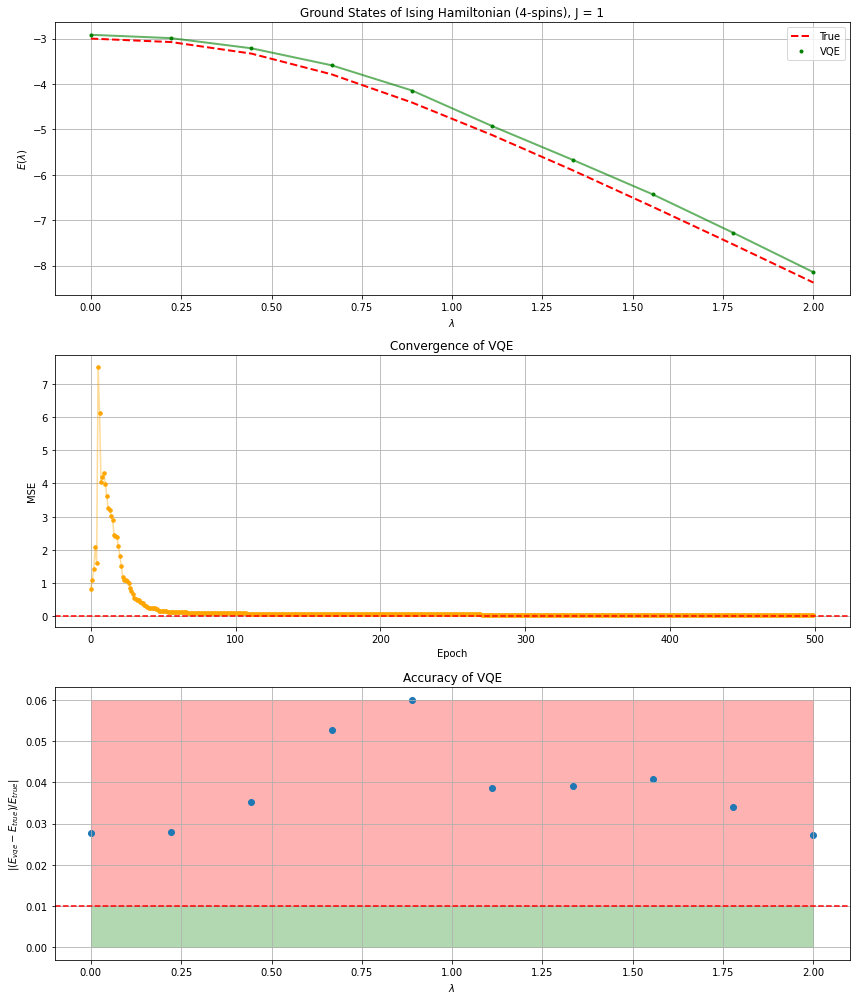

In [32]:
start = time.time()
_,mse_spsa,_,_ = vqe.mptrain(step_size = study.best_params['step_size'], n_epochs = 500, N = 4, J = 1, l_steps = 10, vqe_cost_fn = vqe_cost_fn_mixed, optimizer = 'SPSA',
      random_shift = study.best_params['random_shift'], shift_invariance = 0, p_noise = 0.001, p_noise_ent = 0.001, 
      circuit = True, plots = True, prepare_states = False, preplots = True,
      prep_step_size = 0.1, cutoff_value = 0.01, pretrained = preparams)
stop = time.time()

time_spsa = stop - start

***Parameters:***

step_size    = 0.01 (Step size of the optimizer)
random_shift = 0.2 (Random shift of parameters of the optimizer)
n_epochs     = 500 (# epochs for the other GSs)
N            = 4 (Number of spins of the system)


***Circuit:***

0: ──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)─┤ ╭<𝓗>
1: ──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)─┤ ├<𝓗>
2: ──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)─┤ ├<𝓗>
3: ──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)─┤ ╰<𝓗>


  0%|          | 0/500 [00:00<?, ?it/s]

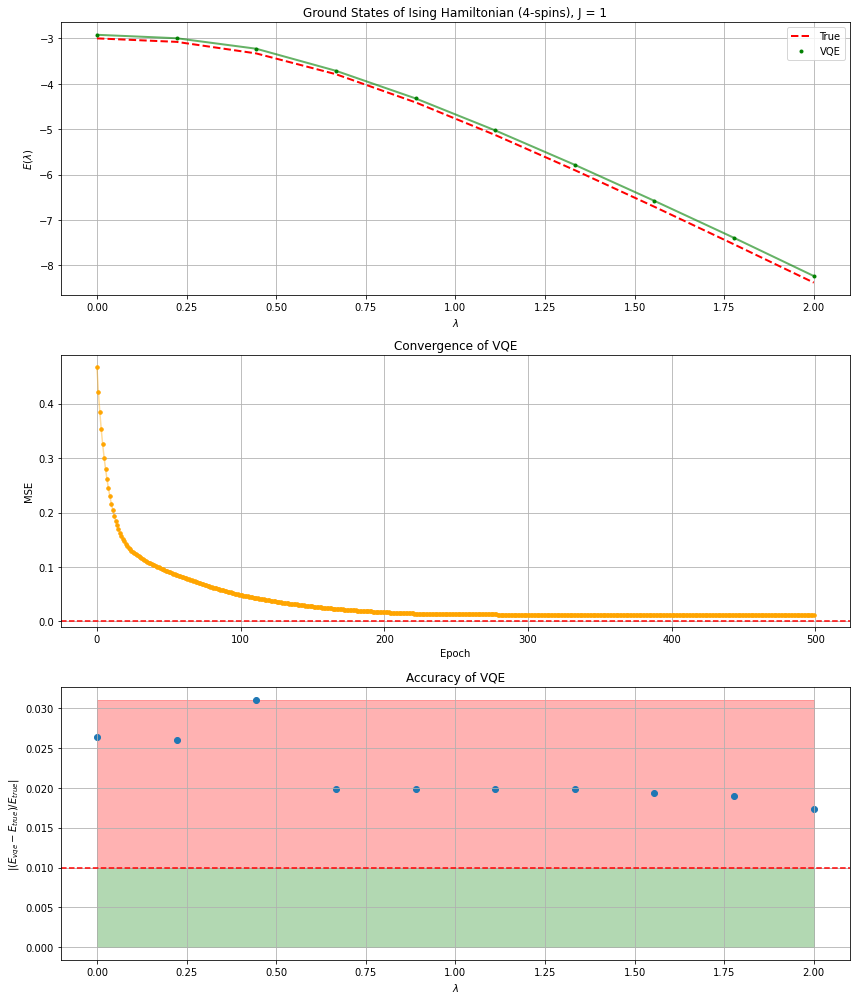

In [36]:
start = time.time()
_,mse_adam,_,_ = vqe.mptrain(step_size = 0.01, n_epochs = 500, N = 4, J = 1, l_steps = 10, vqe_cost_fn = vqe_cost_fn_mixed, optimizer = 'Adam',
      random_shift = 0.2, shift_invariance = 0, p_noise = 0.001, p_noise_ent = 0.001, 
      circuit = True, plots = True, prepare_states = False, preplots = True,
      prep_step_size = 0.1, cutoff_value = 0.01, pretrained = preparams)
stop = time.time()

time_adam = stop - start

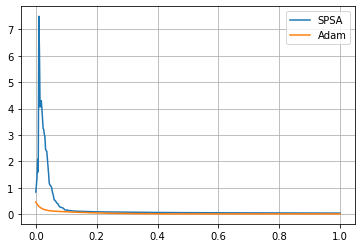

MSE (SPSA) : 0.04234 | TIME (SPSA) : 134.4800992012024
MSE (ADAM) : 0.01191 | TIME (ADAM) : 1555.7676000595093


In [37]:
plt.plot(np.linspace(0,1,len(mse_spsa)), mse_spsa, label = 'SPSA')
plt.plot(np.linspace(0,1,len(mse_adam)), mse_adam, label = 'Adam')
plt.legend()
plt.grid(True)
plt.show()

print('MSE (SPSA) : {0} | TIME (SPSA) : {1}'.format(np.round(mse_spsa[-1],5), time_spsa) )
print('MSE (ADAM) : {0} | TIME (ADAM) : {1}'.format(np.round(mse_adam[-1],5), time_adam) )